In [57]:
from hmmlearn import hmm
import pickle

with open('dataset_mrna.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
    
X_train[0:5]

[[2, 1, 0, 3, 1, 0, 1, 3, 0, 2, 0, 3, 1, 1, 3, 1, 3, 3],
 [1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 3, 0, 0, 0],
 [3, 2, 1, 3, 2, 0, 1, 2, 0, 2, 0, 1, 1, 3, 2, 3, 2, 3],
 [3, 1, 3, 0, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 1, 3, 3, 0],
 [0, 2, 3, 0, 3, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 1, 3]]

In [58]:
seqs = []
# Train HMM with only X_train sequences
for i in range(len(X_train)):
    if y_train[i]==1:
        seqs.append(X_train[i])

seqs[0:10], len(seqs)

([[1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 3, 0, 0, 0],
  [3, 1, 3, 0, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 1, 3, 3, 0],
  [0, 2, 3, 0, 3, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 1, 3],
  [3, 3, 0, 2, 2, 3, 0, 2, 2, 2, 1, 2, 2, 3, 0, 3, 2, 1],
  [2, 0, 2, 0, 3, 0, 3, 0, 2, 1, 2, 1, 2, 2, 1, 2, 3, 1],
  [2, 3, 0, 3, 3, 2, 0, 2, 2, 2, 2, 0, 0, 0, 3, 0, 2, 1],
  [1, 1, 3, 3, 3, 0, 2, 0, 2, 3, 2, 1, 2, 2, 2, 0, 3, 1],
  [2, 3, 0, 0, 2, 1, 1, 1, 2, 0, 2, 2, 1, 3, 0, 2, 3, 1],
  [2, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 3, 3, 3, 1, 1, 2, 3],
  [0, 2, 1, 1, 3, 1, 0, 3, 2, 1, 2, 0, 0, 2, 0, 0, 3, 0]],
 139)

In [59]:
import numpy as np
train_seq = np.array([], dtype=int)
train_len = np.array([], dtype=int)

for i in range(len(seqs)):
    train_seq = np.concatenate((train_seq, seqs[i]))
    train_len = np.append(train_len, len(seqs[i]))

# HMM model train

In [60]:
N_states=2

In [61]:
a = np.vstack((np.array([0.7,0.3]),
              np.array([0.7,0.3])))
a = a / a.sum(axis=1)[:, np.newaxis]

e = np.vstack((np.ones(4),
               np.array([1,0.1,3,0.1])))
e = e / e.sum(axis=1)[:, np.newaxis]

pi = np.array([1,0])
a, e, pi

(array([[0.7, 0.3],
        [0.7, 0.3]]), array([[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.23809524, 0.02380952, 0.71428571, 0.02380952]]), array([1, 0]))

In [62]:
HMM_bind = hmm.MultinomialHMM(n_components=N_states, init_params='', params='et')
HMM_bind.transmat_ = a
HMM_bind.emissionprob_ = e
HMM_bind.startprob_ = pi

HMM_bind.fit(train_seq.reshape(-1,1), train_len)
HMM_bind.monitor_.converged

True

In [63]:
X_train_lh = [] # log-likelihood
for i, seq in enumerate(X_train):
    X_train_lh.append([HMM_bind.score(np.array(seq).reshape(-1,1))])
    
X_test_lh = [] # log-likelihood
for i, seq in enumerate(X_test):
    X_test_lh.append([HMM_bind.score(np.array(seq).reshape(-1,1))])

# Train logistic classifier

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=1000)
clf = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

In [65]:
clf.fit(X_train_lh, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('clf',
                 LogisticRegressionCV(cv=10, max_iter=1000,
                                      scoring='roc_auc'))])

In [66]:
predicted = clf.predict_proba(X_test_lh)
positive_column = list(clf.classes_).index(1)

y_pred = predicted[:, positive_column]

fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
test_score = roc_auc_score(y_test, y_pred)
print(test_score)

0.7627118644067796


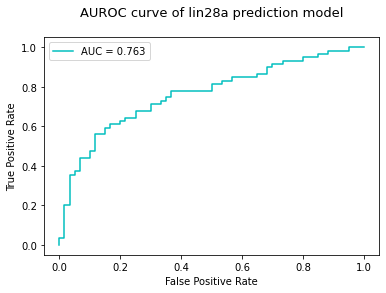

In [67]:
from matplotlib import pyplot as plt
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(test_score),c='c') #marker='.'
 
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'AUROC curve of lin28a prediction model\n', size=13)
plt.legend()
plt.show()

In [68]:
with open('HMM_results_mrna.pkl', 'wb') as f :
    pickle.dump((fpr,tpr,test_score), f)